## Import the Required Data and Libraries

In [28]:
%pip install matplotlib
%pip install matplotlib-inline
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install geopy
%pip install geopandas
%pip install tenacity
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import geopandas as gpd
import DBScan as db
import LocationFinder

In [2]:
import os
import warnings
from tqdm import tqdm

## Perform Exploratory Data Analysis

In [3]:
DATA_DIRECTORY = "../data"
RAW_DATA_FILE = f"{DATA_DIRECTORY}/database_raw.csv"

assert os.path.isdir(DATA_DIRECTORY)
assert os.path.isfile(RAW_DATA_FILE)

In [4]:
raw_df = pd.read_csv(RAW_DATA_FILE)

In [5]:
dates_df = raw_df[~raw_df["Time"].str.endswith("Z")].copy()
dates_df["Date"] = pd.to_datetime(dates_df["Date"])
dates_df.sort_values(by="Date", inplace=True)
dates_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [6]:
earliest_yr = dates_df.iloc[0, 0].year
latest_yr = dates_df.iloc[-1, 0].year
print(f"The earliest year in the dataset is {earliest_yr}")
print(f"The latest year in the dataset is {latest_yr}")

The earliest year in the dataset is 1965
The latest year in the dataset is 2016


##### Our insight from this visualization is that this dataset contains mostly recent earthquakes, making it more relevant for our problem

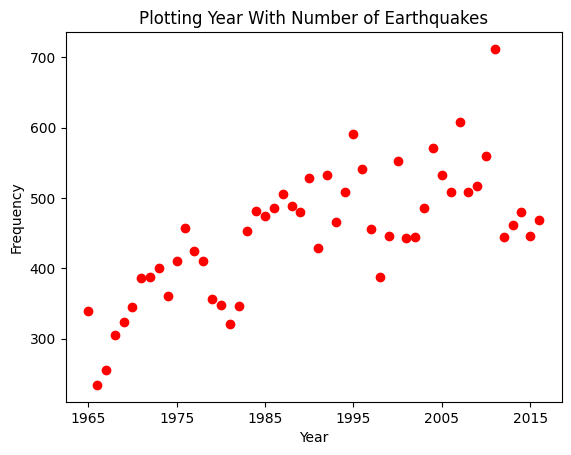

In [7]:
years = [yr for yr in range(1965, 2016+1)]
year_frequencies = [0 for _ in range(len(years))]

for date in dates_df["Date"]:
    yr = date.year
    year_frequencies[yr-1965] += 1

plt.title("Plotting Year With Number of Earthquakes")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks([years[i] for i in range(len(years)) if i % 10 == 0])
plt.scatter(years, year_frequencies, color="red")
plt.show()

#### Explore the different types in this dataset

Our conclusion from this is that there is an insufficient amount of tuples with explosions to make any meaningful analysis. There are precisely 4 such tuples. Therefore, this attribute should be removed.

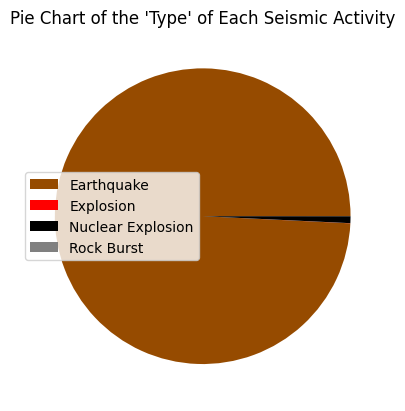

In [8]:
types = list(np.unique(raw_df["Type"].values))
type_frequencies = [0 for _ in range(len(types))]
type_hash = dict()

for i, tp in enumerate(types):
    type_hash[tp] = i

for tp in raw_df["Type"].values:
    type_frequencies[type_hash[tp]] += 1

plt.title("Pie Chart of the 'Type' of Each Seismic Activity")
plt.pie(type_frequencies,
        colors=['#964B00', 'red', "black", "gray"])
plt.legend(labels=types)
plt.show()

#### Explore the different magnitude types in this dataset

Our conclusion from this is that there are various types of magnitude types that are represented in sizable proportions, which could be useful for further analysis.

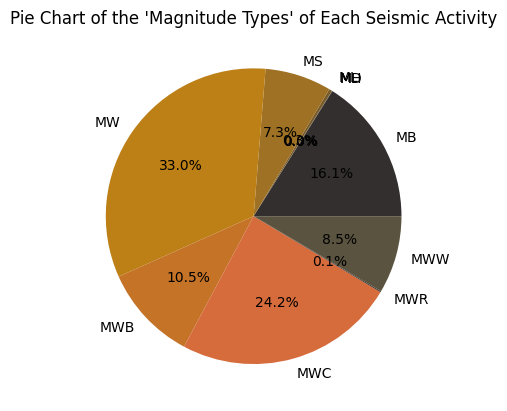

In [9]:
mag_types = list(np.unique(raw_df["Magnitude Type"].dropna().apply(str).values))
mag_type_frequencies = [0 for _ in range(len(mag_types))]
mag_type_hash = dict()

for i, tp in enumerate(mag_types):
    mag_type_hash[tp] = i

for tp in raw_df["Magnitude Type"].values:
    if tp not in mag_types:
        continue
    mag_type_frequencies[mag_type_hash[tp]] += 1

plt.title("Pie Chart of the 'Magnitude Types' of Each Seismic Activity")
plt.pie(mag_type_frequencies,
        labels=mag_types,
        autopct='%1.1f%%',
        colors=["#332F2E", "#59533F", "#473D2C", "#785B2A", "#9E7124", "#BD8017", "#C47327", "#D66B3C"])
plt.show()

## Data Pre-Processing

#### Observation Removal
- `Type`: Too much data imbalance for different classes, and only 'Earthquake' class is relevant anyway
- `Date`/`Time`: There were 3 entries with Date/Time in a different format. Since it is such a small portion of the data we simply removed these entries

#### Feature Selection (Removal)
- `Time`: Not terribly relevant for clustering and outlier detection
- `Type`: Only Earthquake was kept so feature is constant
- `ID`: Completely irrelevant in earthquake analysis
- `Source`: We are assuming the sources are reliable
- `Depth Error`, `Depth Seismic Stations`, `Magnitude Error`, `Magnitude Seismic Stations`, `Azimuthal Gap`, `Horizontal Distance`, `Horizontal Error`, `Location Source`, `Magnitude Source`, `Status`: Significant portion of values are missing and/or feature is not relevant to our problem.

In [10]:
df = raw_df.copy()

df = df[df["Type"] == "Earthquake"]

df = df.drop(['Depth Error','Depth Seismic Stations','Magnitude Error', 'Magnitude Seismic Stations','Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'Location Source', 'Magnitude Source', 'Status', 'ID', 'Source', 'Type'], axis=1)

df = df[~df["Date"].str.endswith("Z")]
df = df[~df["Time"].str.endswith("Z")]

DATA_FILE = f"{DATA_DIRECTORY}/earthquakes.csv"
df.to_csv(DATA_FILE, index=False)

#### Feature Creation
- `Country`: The country that this earthquake occurred in ("Ocean" if not belonging to a country)
- `State`: The state that this earthquake occurred in ("Ocean" if not belonging to a state)

In [11]:
num_samples = df.shape[0]
latitudes = list(df["Latitude"])
longitudes = list(df["Longitude"])
countries = []
states = []

In [ ]:
for i in tqdm(range(num_samples)):
    lat = latitudes[i]
    long = longitudes[i]
    locationDict = LocationFinder.getLocation(lat, long)
    if "country" not in locationDict:
        countries.append("Ocean")
        states.append("Ocean")
    else:
        cur_country = locationDict["country"]
        cur_state = locationDict["state"]
        countries.append(cur_country)
        states.append(cur_state)

  6%|██▏                                 | 1412/23229 [32:21<9:23:18,  1.55s/it]

Error:  HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=-16.167&lon=-173.704&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


  6%|██▏                                 | 1435/23229 [32:54<6:24:27,  1.06s/it]

In [24]:
df["Country"] = countries
df["State"] = states

In [25]:
df.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Country
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,MW,s
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,MW,s
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,MW,s
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,MW,s
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,MW,s


## Perform DBScan

In [20]:
epsilon = 350
minSamp = 5
cluster_minObs = 10
DBSCAN_OUTPUT_FILE = f"{DATA_DIRECTORY}/dbscan_out.csv"
df['Cluster'] = db.DBScan(DATA_FILE, epsilon, minSamp, DBSCAN_OUTPUT_FILE)

## Load DBScan Data, Fault Line Data, and World Map

In [23]:
if 'Cluster' not in df.columns:
    df['Cluster'] = pd.read_csv(DBSCAN_OUTPUT_FILE)['Cluster']

for cid, group in df.groupby('Cluster'):
    if(cid == -1): continue
    print(f"Cluster {cid}: {len(group)} events")

warnings.filterwarnings("ignore", category=UserWarning)
GEM_GAF_DB = gpd.read_file("../data/fault_lines.geojson")

#GEM_GAF_DB = GEM_GAF_DB.to_crs(epsg=3857)

GEM_GAF_DB['plot_lon'] = GEM_GAF_DB.geometry.centroid.x
GEM_GAF_DB['plot_lat'] = GEM_GAF_DB.geometry.centroid.y

world = gpd.read_file(f"{DATA_DIRECTORY}/worldmap_database/ne_110m_admin_0_countries.dbf")

Cluster 1: 17157 events
Cluster 2: 898 events
Cluster 3: 437 events
Cluster 4: 3415 events
Cluster 5: 221 events
Cluster 6: 265 events
Cluster 7: 17 events
Cluster 8: 42 events
Cluster 9: 117 events
Cluster 10: 31 events
Cluster 11: 13 events
Cluster 12: 82 events
Cluster 13: 6 events
Cluster 14: 10 events
Cluster 15: 7 events
Cluster 16: 26 events
Cluster 17: 48 events
Cluster 18: 14 events
Cluster 19: 95 events
Cluster 20: 5 events
Cluster 21: 24 events
Cluster 22: 6 events
Cluster 23: 16 events
Cluster 24: 9 events
Cluster 25: 24 events
Cluster 26: 13 events
Cluster 27: 16 events
Cluster 28: 5 events
Cluster 29: 8 events
Cluster 30: 6 events
Cluster 31: 4 events
Cluster 32: 5 events


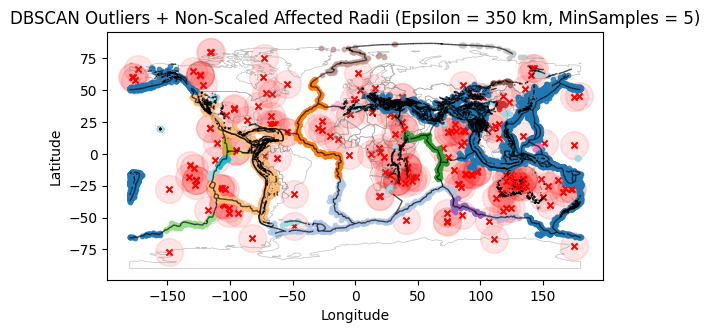



num_outliers: 187

Outlier Average Magnitude = 5.871122994652407
Outlier Median Magnitude = 5.7



In [24]:
world.boundary.plot(ax=plt.gca(), color='gray', linewidth=0.5, alpha=0.5)

# geojson overlay
# form lines from centroids ax
GEM_GAF_DB.plot(ax=plt.gca(), color='black', linewidth=1, label='GEM GAF-DB', alpha=0.7)

df['Cluster'] = df['Cluster'].fillna(-1).astype(int)

clusters = sorted([c for c in df['Cluster'].unique() if c != -1])
num_clusters = len(clusters)
cmap = plt.colormaps['tab20']
cluster_colors = {cid: cmap(i) for i, cid in enumerate(clusters)}

clusters = sorted(df['Cluster'].unique())
cluster_handles = []

for cluster_id in clusters:
    points = df[df['Cluster'] == cluster_id]
    
    # outliers
    if cluster_id == -1:
        plt.scatter(points["Longitude"], points["Latitude"], color='red', marker='o', s=400, alpha=0.1)
        plt.scatter(points["Longitude"], points["Latitude"], color='red', marker='x', s=20, label='Outliers + affected radius')
    # clusters
    else:
        color = cluster_colors[cluster_id]
        handle = plt.scatter(points["Longitude"], points["Latitude"],
                            s=10, alpha=0.8, color=color,
                            label=f"Cluster {cluster_id}")


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Outliers + Non-Scaled Affected Radii (Epsilon = {epsilon} km, MinSamples = {minSamp})")
#plt.legend(title="Cluster Groups", loc="upper left")
plt.show()

outliers = df[df['Cluster'] == -1]
print("\n")
print(f"num_outliers: {len(outliers)}\n")
print(f"Outlier Average Magnitude = {np.mean(outliers['Magnitude'])}")
print(f"Outlier Median Magnitude = {np.median(outliers['Magnitude'])}\n")

#### For this particular data file, find the locations of the anomalies

In [53]:
anomalies_df = df[df["Cluster"] == -1]
anomalies_df.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Cluster
82,03/06/1965,11:10:51,-18.425,-132.923,10.0,5.6,MW,-1
280,10/07/1965,03:36:02,12.347,114.485,20.0,5.9,MW,-1
477,07/12/1966,18:53:11,44.707,37.272,39.3,5.7,MW,-1
636,03/13/1967,19:22:19,19.581,38.874,20.0,5.6,MW,-1
724,08/13/1967,22:07:48,43.094,-0.731,10.0,5.7,MW,-1


In [54]:
num_anomalies = anomalies_df.shape[0]
anomalies_latitude = np.array(anomalies_df["Latitude"])
anomalies_longitude = np.array(anomalies_df["Longitude"])
print("Latitudes: ", anomalies_latitude[:5])
print("Longitudes: ", anomalies_longitude[:5])

Latitudes:  [-18.425  12.347  44.707  19.581  43.094]
Longitudes:  [-132.923  114.485   37.272   38.874   -0.731]


In [155]:
relevant_attributes = [
    "Latitude",
    "Longitude",
    "Magnitude",
    "State",
    "Country"
]
anomaly_country_df = anomalies_df[relevant_attributes]

None
{}
None
{}
Краснодарский край, Россия
{'city': '', 'state': 'Краснодарский край', 'country': 'Россия', 'code': 'ru', 'zipcode': None}
None
{}
Chemin de Capdelabatch, Salies, Arette, Oloron-Sainte-Marie, Pyrénées-Atlantiques, Nouvelle-Aquitaine, France métropolitaine, 64570, France
{'city': '', 'state': 'Nouvelle-Aquitaine', 'country': 'France', 'code': 'fr', 'zipcode': '64570'}
Patan, Satara, Maharashtra, India
{'city': '', 'state': 'Maharashtra', 'country': 'India', 'code': 'in', 'zipcode': None}


In [ ]:
anomaly_country_df.sort_values(by="Magnitude", ascending=False, inplace=True)

In [ ]:
# Printing out top 50 anomaly magnitudes
for i, row in enumerate(anomaly_country_df):
    if i % 50 == 0:
        break
    print(f"{i+1}) {row['State']}, {row['Country']}")